## MODELO B: Eliminación de Toxicidad en Textos

En esta segunda tarea se tratará de desarrollar un modelo para neutralizar las frases con caracter tóxico. El objetivo es que la entrada sea una secuencia de tokens tóxicos y la salida una secuencia neutral semánticamente equivalente. Para ello, se ha elegido el uso de una arquitectura Sequence-to-Sequence (Seq2Seq) con Atención.

# 1. Configuración Inicial, Arquitectura y Funciones Auxiliares

El primer paso es definir la arquitectura del modelo **Seq2Seq con Atención** (Encoder, Attention, Decoder), junto con todas las funciones auxiliares para el preprocesamiento, el entrenamiento y la inferencia.

### Arquitectura Seq2Seq con Atención

La tarea de detoxificación (traducción de frase tóxica a neutral) tendrá la siguiente estructura:

1.  **Encoder:** Implementado con una **GRU Bidireccional**. Procesa la secuencia de entrada (frase tóxica) y genera un conjunto de vectores de contexto y un estado oculto inicial para el Decoder.
2.  **Attention:** Permite al **Decoder** determinar dinámicamente qué tokens de la frase tóxica son más relevantes al generar la siguiente palabra neutral.
3.  **Decoder:** Implementado con una GRU unidireccional. Genera la secuencia de salida, utilizando el estado oculto anterior y un **vector de contexto ponderado** por la capa de Atención.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 25 # Longitud máxima de las secuencias para padding y truncamiento, la explicación de la elección de la longitud se encuentra en el notebook del otro modelo pero en resumen es que el 99.9% de las frases tienen menos de 25 tokens.

print(f"DETOXIFICACIÓN CON MODELO SEQ2SEQ Y ATENCIÓN")

# --- Clases de Preprocesamiento de Datos ---
# Clase de Vocabulario para mapear palabras a índices y viceversa
class Vocabulary:
    def __init__(self): # Inicialización de tokens especiales y sus índices fijos
        # <PAD>: de relleno, <SOS>: inicio de secuencia, <EOS>: fin de secuencia, <UNK>: desconocido
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.n_words = 4

    def add_sentence(self, tokens): # Añade los tokens de una frase al vocabulario si no existen
        for word in tokens:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words += 1

# Dataset personalizado para PyTorch
class DetoxDataset(Dataset):
    """Dataset para PyTorch que convierte tokens a índices y aplica padding."""
    def __init__(self, df, vocab, max_len=25, src_col='en_toxic_comment_tokens', trg_col='en_neutral_comment_tokens'):
        self.df = df
        self.vocab = vocab
        self.max_len = max_len
        self.src_col = src_col
        self.trg_col = trg_col

    def __len__(self):
        return len(self.df)

    def text_to_indices(self, tokens):
        """Convierte tokens a índices, usando <UNK> (3) y añadiendo <EOS> (2)."""
        indices = [self.vocab.word2index.get(t, 3) for t in tokens]
        indices.append(2)
        return indices

    def __getitem__(self, idx):
        src_tokens = self.df.iloc[idx][self.src_col]
        trg_tokens = self.df.iloc[idx][self.trg_col]

        src_indices = self.text_to_indices(src_tokens)
        trg_indices = self.text_to_indices(trg_tokens)

        # Padding/Truncamiento Manual
        if len(src_indices) < self.max_len: # Relleno hasta max_len
            src_indices += [0] * (self.max_len - len(src_indices))
        else: # Truncamiento si excede max_len
            src_indices = src_indices[:self.max_len]

        if len(trg_indices) < self.max_len: # Relleno hasta max_len
            trg_indices += [0] * (self.max_len - len(trg_indices))
        else: # Truncamiento si excede max_len
            trg_indices = trg_indices[:self.max_len]

        return torch.tensor(src_indices, dtype=torch.long), torch.tensor(trg_indices, dtype=torch.long)

# Definición de la Arquitectura Seq2Seq con Atención. Codificador: GRU Bidireccional para generar los outputs de contexto de la secuencia de entrada
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # Bidireccional para capturar el contexto pasado y futuro
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
        # Colapsa los dos estados ocultos finales (forward y backward) en uno solo para el Decoder
        self.fc = nn.Linear(hid_dim * 2, hid_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        return outputs, hidden

# Mecanismo de Atención: Calcula los pesos de relevancia del Encoder outputs en cada paso de decodificación
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()

        # Capa para calcular la 'energía' (alineamiento)
        self.attn = nn.Linear((hid_dim * 2) + hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # Expande el estado oculto del decoder para compararlo con cada output del encoder
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    """Decodificador con Atención: GRU que genera la secuencia de salida usando un contexto ponderado."""
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)

        # La GRU recibe el embedding de la palabra anterior concatenado con el vector de contexto
        self.rnn = nn.GRU((hid_dim * 2) + emb_dim, hid_dim, batch_first=True)

        # Capa de salida para la predicción del vocabulario
        self.fc_out = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        # 1. Calcular pesos de atención (a)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)

        # 2. Calcular contexto ponderado (weighted)
        weighted = torch.bmm(a, encoder_outputs)

        # 3. Input del GRU
        rnn_input = torch.cat((embedded, weighted), dim=2) # Concatenar embedding y contexto ponderado (dimensión de las features)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        # 4. Predicción final
        prediction = self.fc_out(torch.cat((output.squeeze(1), weighted.squeeze(1), embedded.squeeze(1)), dim=1))
        return prediction, hidden.squeeze(0)

#Contenedor que integra Encoder y Decoder, gestionando el flujo y el Teacher Forcing
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Codificación
        encoder_outputs, hidden = self.encoder(src)

        input = trg[:, 0] # Primera entrada: <SOS> (índice 1)

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t, :] = output
            top1 = output.argmax(1)

            # Teacher Forcing: usa la palabra real (trg) o la predicha (top1)
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1

        return outputs

#Inicializa los pesos del modelo para evitar la explosión/desvanecimiento de gradientes
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name: nn.init.normal_(param.data, mean=0, std=0.01)
        else: nn.init.constant_(param.data, 0)

# Entrenamiento del modelo, calcula la pérdida y actualiza los pesos
def train(model, iterator, optimizer, criterion, clip):
    model.train()   # Poner el modelo en modo entrenamiento
    epoch_loss = 0  # Inicializar la pérdida 
    for i, (src, trg) in enumerate(iterator): 
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad() # Reiniciar los gradientes
        output = model(src, trg) # Almacenar las salidas del modelo

        # Reshape para la pérdida (excluyendo el <SOS> inicial)
        output_dim = output.shape[-1]  # Dimensión del vocabulario de salida
        output = output[:, 1:].reshape(-1, output_dim)  # Aplanar las salidas
        trg = trg[:, 1:].reshape(-1)  # Aplanar las etiquetas

        loss = criterion(output, trg)  # Calcular la pérdida
        loss.backward() # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Evitar explosión de gradientes
        optimizer.step()  # Actualizar los pesos
        epoch_loss += loss.item()  # Acumular la pérdida

    return epoch_loss / len(iterator)

DETOXIFICACIÓN CON MODELO SEQ2SEQ Y ATENCIÓN


In [2]:
# Con esta funcion cargamos los datos de los archivos.csv, preprocesamos, creamos el vocabulario y generamos los DataLoaders.
def load_data_and_create_vocab(filename, toxic_col, neutral_col):
    # Carga de los datos
    df_detox = pd.read_csv(filename)

    # ast.literal_eval para convertir las strings que parecen listas en listas reales de tokens
    df_detox[toxic_col] = df_detox[toxic_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df_detox[neutral_col] = df_detox[neutral_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Crear vocabulario compartido
    vocab = Vocabulary()
    for tokens in df_detox[toxic_col]: vocab.add_sentence(tokens)
    for tokens in df_detox[neutral_col]: vocab.add_sentence(tokens)

    # Dividiremos en Train/Test (90-10)
    train_data, test_data = train_test_split(df_detox, test_size=0.1, random_state=42)

    # Crear DataLoaders
    train_loader = DataLoader(DetoxDataset(train_data, vocab, MAX_LEN, toxic_col, neutral_col), batch_size=32, shuffle=True)
    test_loader = DataLoader(DetoxDataset(test_data, vocab, MAX_LEN, toxic_col, neutral_col), batch_size=32, shuffle=False)

    return vocab, train_loader, test_loader, len(df_detox)

In [3]:
# Función para neutralizar una frase a partir de un modelo entrenado
def detoxify_sentence(sentence, model, vocab, device, max_len=25):
    model.eval()  # Ponemos el modelo en modo evaluación (desactivar capas como Dropout y BatchNorm)

    # Tokenización y conversión de la frase a índices
    tokens = sentence.lower().split()   # Convertimos la frase a minúsculas y la tokenizamos
    indices = [vocab.word2index.get(t, 3) for t in tokens]  # Usamos <UNK> (3) para palabras desconocidas
    indices.append(2) # EOS sirve para indicar el final de la secuencia

    if len(indices) < max_len: indices += [0] * (max_len - len(indices))  # Padding con <PAD> (0)
    else: indices = indices[:max_len]   # Truncamiento si la secuencia es demasiado larga

    # Preparar tensores de entrada
    src_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    trg_tensor = torch.zeros((1, max_len), dtype=torch.long).to(device)
    trg_tensor[0, 0] = 1 # SOS sirve como inicio de la secuencia

    # Inferencia sin Teacher Forcing
    with torch.no_grad():
        output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0)
        pred_token_ids = output.argmax(2).squeeze().tolist()

    # Convertir índices predichos a palabras, deteniendo en EOS (establecido anteriormente)
    pred_words = []
    for idx in pred_token_ids:
        if idx == 2: break # Detiene en EOS (End Of Sequence)
        if idx not in [0, 1, 2, 3]:
            pred_words.append(vocab.index2word[idx])

    return " ".join(pred_words)

In [4]:
#Función para plotear la atención de una frase dada y su frase generada
def plot_attention(sentence, predicted_sentence, attention_scores):
    attention_matrix = torch.cat(attention_scores, dim=0).cpu().numpy()
    src_tokens = sentence.lower().split() + ['<EOS>']
    trg_tokens = predicted_sentence.split()

    attention_matrix = attention_matrix[:len(trg_tokens), :len(src_tokens)]

    fig = plt.figure(figsize=(12, 8))
    sns.heatmap(attention_matrix,
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap='viridis',
                linewidths=0.1,
                cbar_kws={'label': 'Intensidad de Atención'})

    plt.xlabel('Frase Tóxica (Input)')
    plt.ylabel('Frase Neutral (Generada)')
    plt.title(f'Atención: "{sentence}" -> "{predicted_sentence}"')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()


# 2. Carga de Datos y Creación de Vocabulario (Modelo 1 - Pequeño)


Para este primer modelo, usaremos los pares de frases de 'english_paradetox_preprocessed_non_lemmatized.csv'. El conjunto de datos solo tiene 400 pares.Esta limitación de datos y vocabulario puede afectar a el rendimiento del Modelo 1 por lo que en el siguiente modelo trataremos de usar un conjunto mayor (así también se podrá comparar el rendimiento de dos modelos iguales entrenados con diferente cantidad de datos).

In [5]:
# Carga de Datos y Vocabulario (Modelo 1 / Dataset Pequeño: 400 pares)
DATASET1_FILE = "datos/english_paradetox_preprocessed_non_lemmatized.csv"
SRC_COL1 = 'toxic_sentence_tokens'
TRG_COL1 = 'neutral_sentence_tokens'

vocab1, train_loader1, _, total_pairs1 = load_data_and_create_vocab(DATASET1_FILE, SRC_COL1, TRG_COL1)

print(f"--- DETALLES DEL MODELO 1 (Dataset Pequeño) ---")
print(f"Total de pares tóxico-neutral: {total_pairs1}")
print(f"Tamaño del vocabulario: {vocab1.n_words}")

--- DETALLES DEL MODELO 1 (Dataset Pequeño) ---
Total de pares tóxico-neutral: 400
Tamaño del vocabulario: 1391


# 3. Inicialización y Entrenamiento del Modelo 1

El modelo Seq2Seq será entrenado durante 20 épocas. Para ello, el primer paso ha sido la inicialización del vocabulario, que debido al tamaño del conjunto se ve que tiene 1391 de tamaño(1,391 palabras).

Se entrenará el modelo Seq2Seq con el Dataset Pequeño durante 20 épocas.

Se utiliza el optimizador Adam para ajustar los pesos del modelo, minimizando la función de pérdida CrossEntropyLoss. Se establece que la pérdida ignore el token de padding (<PAD>) para evitar que el ruido afecte el aprendizaje.

Mecanismo de Estabilidad: Durante cada paso de backpropagation, se aplica Gradient Clipping (límite de 1) a los gradientes. Esto es esencial para prevenir el problema de Explosión de Gradientes, común en arquitecturas recurrentes como la GRU.


In [6]:
# --- Inicialización del Modelo 1 ---
INPUT_DIM = vocab1.n_words
OUTPUT_DIM = vocab1.n_words

ENC_EMB_DIM = 128 # Dimensión de embedding del encoder
DEC_EMB_DIM = 128 # Dimensión de embedding del decoder
HID_DIM = 256 # Dimensión oculta de la GRU

DROPOUT = 0.5 # Dropout de 0.5 para evitar overfitting
N_EPOCHS = 20

attn1 = Attention(HID_DIM)
enc1 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT)
dec1 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn1)
model1 = Seq2Seq(enc1, dec1, device).to(device)
model1.apply(init_weights)

optimizer1 = optim.Adam(model1.parameters())  
criterion = nn.CrossEntropyLoss(ignore_index=0) # Pérdida que ignora <PAD>

#  Entrenamiento 
print("\n--- Entrenando Modelo 1 (20 Épocas) ---")
loss_results1 = []
for epoch in range(N_EPOCHS):
    loss = train(model1, train_loader1, optimizer1, criterion, 1)   # Entrenamiento por época
    loss_results1.append(loss)  # Almacenar la pérdida de la época
    print(f'Epoch: {epoch+1} | Loss: {loss:.4f}') # Mostrar pérdida por época

results1_train_loss = loss_results1[-1]


--- Entrenando Modelo 1 (20 Épocas) ---
Epoch: 1 | Loss: 6.9636
Epoch: 2 | Loss: 5.9036
Epoch: 3 | Loss: 5.7477
Epoch: 4 | Loss: 5.6659
Epoch: 5 | Loss: 5.5980
Epoch: 6 | Loss: 5.5414
Epoch: 7 | Loss: 5.4346
Epoch: 8 | Loss: 5.2557
Epoch: 9 | Loss: 5.2087
Epoch: 10 | Loss: 5.0893
Epoch: 11 | Loss: 4.9403
Epoch: 12 | Loss: 4.8697
Epoch: 13 | Loss: 4.6779
Epoch: 14 | Loss: 4.5885
Epoch: 15 | Loss: 4.4861
Epoch: 16 | Loss: 4.4216
Epoch: 17 | Loss: 4.3302
Epoch: 18 | Loss: 4.2203
Epoch: 19 | Loss: 4.1276
Epoch: 20 | Loss: 3.9744



# 4. Inferencia y Prueba de Concepto (Modelo 1)

Evaluaremos el primer modelo a partir de frases de caracter tóxico. Los resultados deben confirmar la baja capacidad de generalización.

In [34]:
# Frases de prueba
test_sentences = [
    "i will let you die",
    "fire black athletes",
    "stupid people are everywhere",
    "you are a liar and stupid",
    "many times want to validate stupid actions",
    "trying to get shit done"
]

results1 = {}
for s in test_sentences:
    res = detoxify_sentence(s, model1, vocab1, device)
    results1[s] = res
    print(f"Tóxico:  {s}")
    print(f"Neutral: {res}")
    print("-" * 20)

Tóxico:  i will let you die
Neutral: n't n't n't
--------------------
Tóxico:  fire black athletes
Neutral: care bad
--------------------
Tóxico:  stupid people are everywhere
Neutral: n't bad
--------------------
Tóxico:  you are a liar and stupid
Neutral: n't really really
--------------------
Tóxico:  many times want to validate stupid actions
Neutral: n't n't stay away
--------------------
Tóxico:  trying to get shit done
Neutral: n't n't n't
--------------------


Los resultados sugieren que el modelo no ha logrado aprender la tarea de Transferencia de Estilo.

El modelo recurre a la repetición de tokens frecuentes o estadísticamente "seguros" de su pequeño conjunto de entrenamiento, como "n't", "really", "bad" o "people". Esto ocurre porque estas palabras son comunes y tienen una alta probabilidad de co-ocurrencia en secuencias que no son altamente tóxicas, pero no tienen ninguna relación semántica con la frase de entrada.

En otros casos como "this is fucking garbage" $\rightarrow$ "care", el modelo simplemente colapsa la frase a una o dos palabras genéricas, demostrando que su mecanismo de Atención falló en alinear las partes tóxicas de la entrada con la generación de una secuencia neutral de longitud y significado apropiados.

La función pérdida del modelo es de aproximadamente 4.

# 5 Visualización de la Atención (Modelo 1)

**Propósito:** Analizar la fiabilidad del mecanismo de atención.

Se captura y visualiza el mapa de calor de atención para el Modelo 1.

**Interpretación Clave:**

El mapa de calor probablemente será **ruidoso, difuso o incorrecto**. . Esto significa que, al generar una palabra neutral, el modelo no logra identificar consistentemente la porción relevante de la frase tóxica, lo cual es una consecuencia directa del pobre entrenamiento con datos limitados.

--- VISUALIZACIÓN DE ATENCIÓN (Modelo 1) ---
Frase original: i will let you die
Traducción: n't n't n't


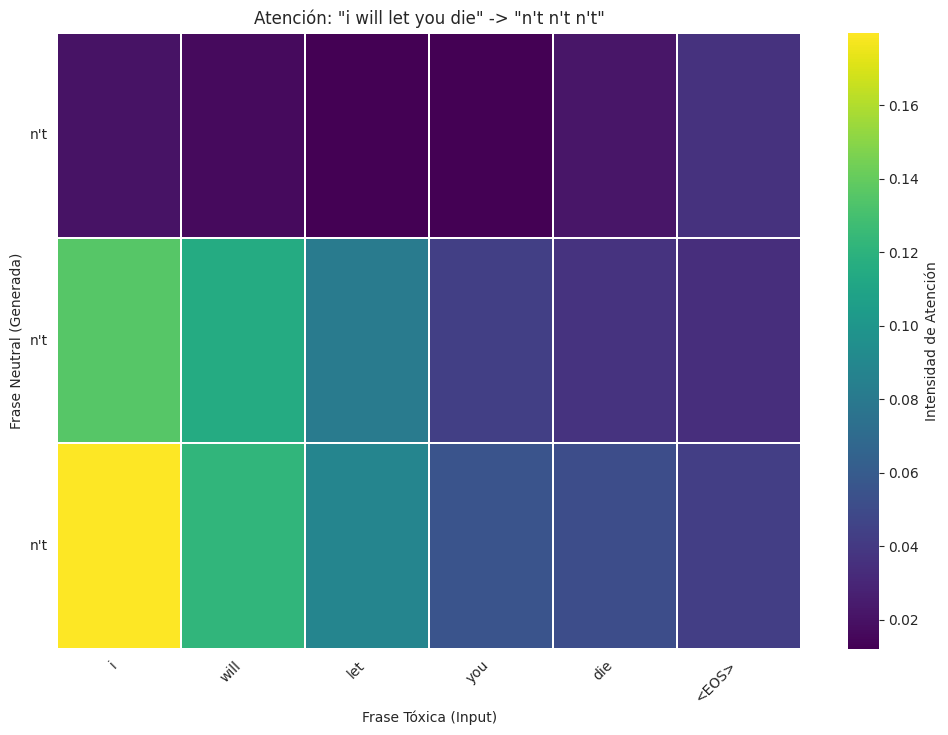

In [27]:
# --- Configuración del Hook ---
attention_weights1 = []
def get_attention_hook1(module, input, output):
    """Hook para capturar el tensor de atención."""
    attention_weights1.append(output.detach())
hook_handle1 = model1.decoder.attention.register_forward_hook(get_attention_hook1)

frase_a_testear = test_sentences[0]

try:
    print(f"--- VISUALIZACIÓN DE ATENCIÓN (Modelo 1) ---")
    attention_weights1 = []
    # Ejecuta la inferencia, activando el hook
    traduccion = detoxify_sentence(frase_a_testear, model1, vocab1, device)

    print(f"Frase original: {frase_a_testear}")
    print(f"Traducción: {traduccion}")

    if len(attention_weights1) > 0:
        # Generar imagen de atención
        plot_attention(frase_a_testear, traduccion, attention_weights1)
    else:
        print("Advertencia: No se capturaron pesos de atención.")

finally:
    hook_handle1.remove() # Se elimina el hook

# 6. Carga de Datos y Creación de Vocabulario (Modelo 2 - Grande)

Para este segundo modelo, usaremos los pares de frases de 'english_paradetox2_preprocessed_non_lemmatized.csv'. El conjunto de datos  tiene 19,744 pares pares. Gracias a esto el vocabulario obtenido consta de más de 13,000 palabras.

Para ello, el primer paso es la creación del vocabulario y la creación de los `DataLoader` de entrenamiento y prueba


In [31]:
# Carga de Datos y Vocabulario (Modelo 2 / Dataset Grande: 19,744 pares) 

DATASET2_FILE = "datos/english_paradetox2_preprocessed_non_lemmatized.csv"
SRC_COL2 = 'en_toxic_comment_tokens' # Columna de tokens tóxicos
TRG_COL2 = 'en_neutral_comment_tokens' # Columna de tokens neutrales

vocab2, train_loader2, _, total_pairs2 = load_data_and_create_vocab(DATASET2_FILE, SRC_COL2, TRG_COL2)

print(f"--- DETALLES DEL MODELO 2 (Dataset Grande) ---")
print(f"Total de pares tóxico-neutral: {total_pairs2}")
print(f"Tamaño del vocabulario: {vocab2.n_words}")

--- DETALLES DEL MODELO 2 (Dataset Grande) ---
Total de pares tóxico-neutral: 19744
Tamaño del vocabulario: 13223


# 7. Inicialización y Entrenamiento del Modelo 2

Se entrenará el modelo Seq2Seq con el Dataset Grande durante 20 épocas. Se inicializan las capas del Encoder y Decoder con el tamaño del vocabulario (13,223) y se entrena utilizando utiliza el optimizador Adam y la `CrossEntropyLoss`.

In [12]:
# --- Inicialización del Modelo 2 ---
INPUT_DIM = vocab2.n_words
OUTPUT_DIM = vocab2.n_words

ENC_EMB_DIM = 128 # Dimensión de embedding del encoder
DEC_EMB_DIM = 128 # Dimensión de embedding del decoder

HID_DIM = 256 # Dimensión oculta de la GRU
DROPOUT = 0.5 # Dropout de 0.5 para evitar overfitting
N_EPOCHS = 20

attn2 = Attention(HID_DIM)
enc2 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT)
dec2 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn2)
model2 = Seq2Seq(enc2, dec2, device).to(device)
model2.apply(init_weights)

optimizer2 = optim.Adam(model2.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0) # Pérdida que ignora <PAD>

# Entrenamiento 
print("\n--- Entrenando Modelo 2 (20 Épocas) ---")
loss_results2 = []
for epoch in range(N_EPOCHS):
    loss = train(model2, train_loader2, optimizer2, criterion, 1)
    loss_results2.append(loss)
    print(f'Epoch: {epoch+1} | Loss: {loss:.4f}')

results2_train_loss = loss_results2[-1]


--- Entrenando Modelo 2 (20 Épocas) ---
Epoch: 1 | Loss: 6.7031
Epoch: 2 | Loss: 6.0898
Epoch: 3 | Loss: 5.6196
Epoch: 4 | Loss: 4.9081
Epoch: 5 | Loss: 4.0045
Epoch: 6 | Loss: 3.0843
Epoch: 7 | Loss: 2.3547
Epoch: 8 | Loss: 1.8937
Epoch: 9 | Loss: 1.5841
Epoch: 10 | Loss: 1.3839
Epoch: 11 | Loss: 1.2196
Epoch: 12 | Loss: 1.0890
Epoch: 13 | Loss: 1.0032
Epoch: 14 | Loss: 0.9181
Epoch: 15 | Loss: 0.8473
Epoch: 16 | Loss: 0.7908
Epoch: 17 | Loss: 0.7524
Epoch: 18 | Loss: 0.7031
Epoch: 19 | Loss: 0.6847
Epoch: 20 | Loss: 0.6445


# 8. Inferencia y Prueba de Concepto (Modelo 2)

Se evaluará cualitativamente la capacidad de destoxificación del Modelo 2 en frases nunca vistas.
Se ejecuta la función `detoxify_sentence` en el conjunto de frases de prueba (`test_sentences`) para verificar si el modelo:
1.  **Elimina o transforma** el contenido tóxico (e.g., "stupid idiot", "fucking garbage").
2.  **Mantiene la coherencia** y el sentido de la frase original.

In [35]:
# --- Pruebas de Inferencia (Modelo 2) ---
# Se utilizan las mismas frases definidas en el experimento 1
print("--- RESULTADOS DE DETOXIFICACIÓN (Modelo 2) ---")
results2 = {}
for s in test_sentences:
    res = detoxify_sentence(s, model2, vocab2, device)
    results2[s] = res
    print(f"Tóxico:  {s}")
    print(f"Neutral: {res}")
    print("-" * 20)

--- RESULTADOS DE DETOXIFICACIÓN (Modelo 2) ---
Tóxico:  i will let you die
Neutral: let s end
--------------------
Tóxico:  fire black athletes
Neutral: respect
--------------------
Tóxico:  stupid people are everywhere
Neutral: people complain content
--------------------
Tóxico:  you are a liar and stupid
Neutral: gods uni mean
--------------------
Tóxico:  many times want to validate stupid actions
Neutral: times want validate actions actions actions
--------------------
Tóxico:  trying to get shit done
Neutral: get get done done
--------------------


El modelo ha aprendido a generar secuencias que ya no son únicamente una repetición de tokens seguros (n't really bad).
La función pérdida del modelo es de aproximadamente 0.65.


# 9 Visualización de la Atención (Modelo 2)

**Propósito:** Interpretar el comportamiento interno del Modelo 2 al generar la frase neutral.

Se utiliza un *forward hook* temporal para capturar el tensor de pesos de atención durante la inferencia de una frase de prueba. El mapa de calor resultante muestra la alineación entre los tokens de entrada (Eje X) y los tokens de salida (Eje Y).

**Interpretación Clave:**

El mapa de calor debe mostrar **patrones de atención claros y localizados** (idealmente, una "diagonal" bien marcada), confirmando que el modelo ha aprendido a **alinear con precisión** la palabra neutral con la porción relevante del contexto tóxico. .


--- VISUALIZACIÓN DE ATENCIÓN (Modelo 2) ---
Frase original: many times want to validate stupid actions'
Traducción: times want validate irresponsible person


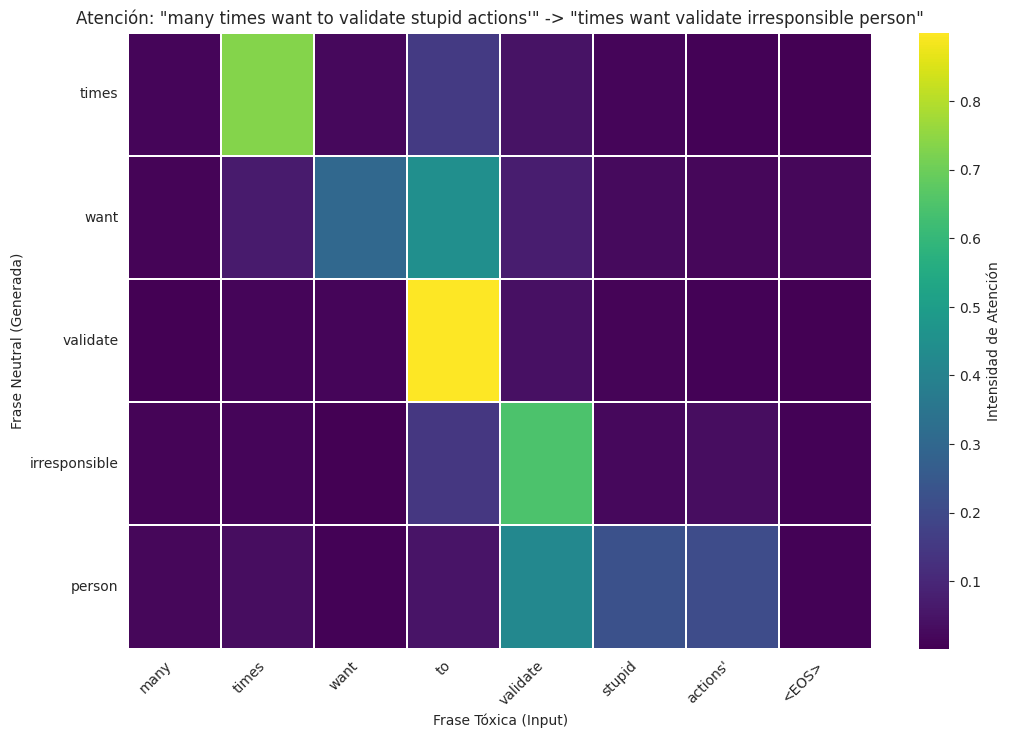

In [25]:
# --- Configuración del Hook ---
attention_weights2 = []
def get_attention_hook2(module, input, output):
    """Hook para capturar el tensor de atención."""
    attention_weights2.append(output.detach())
hook_handle2 = model2.decoder.attention.register_forward_hook(get_attention_hook2)

frase_a_testear = "many times want to validate stupid actions"

try:
    print(f"--- VISUALIZACIÓN DE ATENCIÓN (Modelo 2) ---")
    attention_weights2 = []
    # Ejecuta la inferencia, activando el hook
    traduccion = detoxify_sentence(frase_a_testear, model2, vocab2, device)

    print(f"Frase original: {frase_a_testear}")
    print(f"Traducción: {traduccion}")

    if len(attention_weights2) > 0:
        # Generar imagen de atención
        plot_attention(frase_a_testear, traduccion, attention_weights2)
    else:
        print("Advertencia: No se capturaron pesos de atención.")

finally:
    hook_handle2.remove() # Se elimina el hook para limpiar el modelo

# 10 Conclusión final

Hemos visto que el primer modelo tiene un problema de limitación al contar con un conjunto de datos menor, lo cual le produce underfitting y genera que el modelo siempre tienda a generar tokens seguros. Al escalar el conjunto de entrenamiento, el Modelo 2 demostró que la arquitectura Seq2Seq con Atención es viable y se obtienen mejores resultados, cumpliendo con la función de desintoxicación.

Para la próxima iteración, trataremos de utilizar arquitecturas Transformer. Estos modelos, al haber sido pre-entrenados con vastos datasets en tareas de Seq2Seq y tener un mecanismo de atención más complejo, son ideales para resolver la limitación de coherencia semántica que la GRU con atención del Modelo 2 no pudo superar.


In [ ]:
# ==========================================
# MODELO 3: TRANSFORMER T5 (Detoxificación) - CÓDIGO COMPLETO
# ==========================================
import torch
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import Dataset

# --- PASO 0: CARGAR Y PREPARAR DATOS (Lo que faltaba) ---
print("Cargando y procesando datos para T5...")

# Cargamos el mismo archivo del "Modelo 2 (Grande)"
dataset_file = "datos/english_paradetox2_preprocessed_non_lemmatized.csv"
df = pd.read_csv(dataset_file)

# Columnas del CSV (basado en tu celda 9)
col_origen = 'en_toxic_comment_tokens'
col_destino = 'en_neutral_comment_tokens'

# Función para convertir la representación de lista "['hola', 'mundo']" a texto "hola mundo"
def tokens_to_sentence(text_list_str):
    if isinstance(text_list_str, str) and text_list_str.strip().startswith('['):
        try:
            tokens = ast.literal_eval(text_list_str)
            return " ".join(tokens)
        except:
            return str(text_list_str)
    return str(text_list_str)

# Creamos las columnas de texto limpio que necesita T5
df['toxic_text'] = df[col_origen].apply(tokens_to_sentence)
df['neutral_text'] = df[col_destino].apply(tokens_to_sentence)

# Dividimos en Train y Validation (90% - 10%)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"Datos cargados. Train: {len(train_df)}, Val: {len(val_df)}")

# --- PASO 1: CONVERTIR A DATASET DE HUGGING FACE ---
hf_train = Dataset.from_pandas(train_df[['toxic_text', 'neutral_text']])
hf_val = Dataset.from_pandas(val_df[['toxic_text', 'neutral_text']])

# --- PASO 2: MODELO Y TOKENIZER ---
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# --- PASO 3: PREPROCESAMIENTO ---
prefix = "detoxify: "

def preprocess_function(examples):
    # Añadimos el prefijo "detoxify: " a la entrada
    inputs = [prefix + doc for doc in examples["toxic_text"]]

    # Tokenizamos entradas
    model_inputs = tokenizer(inputs, max_length=64, truncation=True)

    # Tokenizamos salidas (targets)
    # text_target es la forma moderna de hacerlo en transformers
    labels = tokenizer(text_target=examples["neutral_text"], max_length=64, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Mapeamos la tokenización
tokenized_train = hf_train.map(preprocess_function, batched=True)
tokenized_val = hf_val.map(preprocess_function, batched=True)

# --- PASO 4: CONFIGURACIÓN DE ENTRENAMIENTO (Optimizado CPU) ---
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5_detox_output_v2", # <--- CAMBIO DE NOMBRE
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=False,
    use_cpu=True,
    logging_steps=50,
    report_to="none"  # <--- DESACTIVA TENSORBOARD para evitar el error de logs
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Iniciando entrenamiento T5...")
trainer.train()

# --- PASO 5: INFERENCIA / PRUEBA ---
print("\n--- PRUEBA DE RESULTADOS (T5) ---")
ejemplos = [
    "You are a stupid idiot and I hate you",
    "Shut up and die you moron",
    "This is fucking bullshit"
]

# Forzamos CPU para inferencia
device = torch.device("cpu")
model.to(device)

for texto in ejemplos:
    input_text = prefix + texto
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    outputs = model.generate(input_ids, max_length=64)
    traduccion = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"Original: {texto}")
    print(f"Neutral:  {traduccion}")
    print("-" * 30)